# Package and functions

In [2]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *


#General os library 
import os
import time as time_package
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_multiple_jumps import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element



#Path for HQCPC7 
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function

#Path for HQC PC15 
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
import imageio
import scipy.io
from scipy import signal

In [3]:
def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""

    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["const_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_offset(offset_1, offset_2,config,qmm):
    """ Update the input offsets of the qm in the configuration file """
    
    config['controllers']["con1"]["analog_inputs"][1]['offset']=offset_1
    config['controllers']["con1"]["analog_inputs"][2]['offset']=offset_2
    
    
    qm=qmm.open_qm(config)
    
    return config, qm


def plot_init_av_single(I,Q,time,n_avg,bin_size,n_angle,figsize,fontsize,dpi):

    fig, axs = plt.subplots( nrows=3, ncols=2, figsize=figsize,dpi=dpi)

    #Plot without reducing 
    ax=axs[0,0]
    ax.plot(I,Q,".",markersize=2)
    ax.set_title('Pump Frequency '+str(IF_pump)+" Amplitude"+str(amp_factor),fontsize=fontsize)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")

    ax=axs[1,0]
    ax.plot(time,I, ".", markersize=2)
    ax.set_xlabel("Time [s]",fontsize=fontsize)
    ax.set_ylabel("I",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

    ax=axs[2,0]
    ax.hist2d(I,Q,bins=bin_size)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")

    #Plot with reducing 
    average_I, average_Q, time_average=rot_and_av_single(I,Q,time,n_angle,n_avg)

    ax=axs[0,1]
    ax.plot(average_I.transpose(),average_Q.transpose(),".",markersize=2)
    ax.set_title('Pump Frequency '+str(IF_pump)+" Amplitude"+str(amp_factor),fontsize=fontsize)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")


    ax=axs[1,1]
    ax.plot(time_average,average_I[0,:], ".", markersize=2)
    ax.set_xlabel("Time [s]",fontsize=fontsize)
    ax.set_ylabel("I",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax=axs[2,1]
    ax.hist2d(average_I[0,:],average_Q[0,:],bins=bin_size)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")

    print("Average signal : {}".format(np.mean(abs(I))))
    
    
def rot_and_av_single(I,Q,time,nb_angle,n_avg):
    
    #reshape the data to fit into the initial function
    I_2d=np.reshape(I, (1, I.shape[0])) 
    Q_2d=np.reshape(Q, (1, Q.shape[0]))
    rot_I,rot_Q=an.rotate_data(I_2d,Q_2d,nb_angle)
    average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)

    return average_I, average_Q, time_average




def single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm):
    
    """ gets the IQ values for a given pump frequency and amplitude 
    IF_Pump : If frequency of the pump 
    IF_resonator : IF frequency of the resonator (should be calculated before such that it gives half of the pump total frequency (LO_fluxline+IF_pump)/2-LO_readout
    Offset_IF : in case the down converted frequency is not perfectly centered around 0. This is typically kept to zero
    amp_facot amplitude factor of the pump
    n_runs : number of points 
    Readout_delay : waiting time before the first readout in clock cycle
    Readout_Len : time in ns of each readout 
    points_delay: waiting time between collected points 
    qm : quantum manager 

    returns :

    I: vector n_runs components of the frist quadrature
    Q : vector of n_runs compontents of the second quadrature
    time : vector of the time """


    with program() as IQ_blobs:

        n = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
        I_st = declare_stream()
        Q_st = declare_stream()
        f = declare(int)
        
        it_numb_st=declare_stream()

        # Change the of the pump and resonator to demodulate better
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Play a continuous loop sending a pulse through the fluxline 
        

        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300+points_delay*4)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline

        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)
            
            save(n,it_numb_st)

            wait(points_delay,"resonator")
        

        with stream_processing():
            I_st.with_timestamps().save_all("I")
            Q_st.with_timestamps().save_all("Q")
            it_numb_st.save("iteration")


    simulation = False
    if simulation:

        simulation_config = SimulationConfig(
            duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
        )
        job = qmm.simulate(config, IQ_blobs, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    else: 



        job = qm.execute(IQ_blobs)
        results = fetching_tool(job, data_list=["I", "Q","iteration"], mode="live")

        fig = plt.figure()
        interrupt_on_close(fig, job)
        while results.is_processing():

            I, Q,iteration = results.fetch_all()

            time=I["timestamp"]
            I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
            Q = u.demod2volts(Q["value"], Readout_Len)

            #plt.subplot(211)
            plt.subplot(211)
            plt.cla()
            fig.suptitle("IF_pump "+str(IF_pump) +" Progress :"+str(round(iteration/n_runs,2)))
            plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
            plt.xlabel("I")
            plt.ylabel("Q")
            plt.axis("equal")
            plt.subplot(212)
            plt.cla()
            tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
            plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
            plt.xlabel("nb_points")
            plt.ylabel("phase")
            plt.pause(0.1)

        I, Q, iteration = results.fetch_all()
        time=I["timestamp"]
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], Readout_Len)

      
    return time, I, Q



def Update_single_IQ_trace(config,IF_pump,IF_resonator,Offset_IF,amp_factor,qm,nb_desired_jumps,nb_points_between_jumps,init_points_delay=16,nb_angle=100,n_avg=10,init_Readout_Len=50_000,init_nruns=100000,threshold=1e-5 ):

    counter=0
    jumps=[] 
    stop=False
    vaccum=False

    Readout_Len= init_Readout_Len    # Sets the readout to the initial wanted value 
    config,qm=update_readout_lenght(Readout_Len,config,qmm)


    n_runs=init_nruns # set the number_runsto the initial wanted number of runs 
    points_delay=init_points_delay//4 #initial points delay is set to the minimum 

    #First estimate of the total time 
    Total_time=n_runs*(Readout_Len+points_delay*4)*1e-9

    counter+=1

    print("########### Iteration number : {} ##########".format(counter))
    print("The program is initalized with :")
    print("A readout length of {} ns".format(Readout_Len))
    print("The Number of points  {}".format(n_runs))   
    print("An initial point delay  {} ms".format(init_points_delay*4*1e-6))  
    print("Time for iteration  {} min".format(Total_time/60)) 


    # Begins the loop that is stopped under the following conditions : we have more then 90 % of the number of desired jumps but less than twice (otherwise, we might not have the optimal readout length)
    # stop is set to true 

    while stop==False:

        time_package.sleep(1)
        time, I, Q=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm)

        print("Out_of_qm")
        plt.close()
        
        I_2d=np.reshape(I, (1, I.shape[0])) 
        Q_2d=np.reshape(Q, (1, Q.shape[0]))
        rot_I,rot_Q=an.rotate_data(I_2d,Q_2d,nb_angle)
        average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)

        # average_I,average_Q,time_average=rot_and_av_single(I,Q,time,nb_angle,n_avg)
        av = np.mean(abs(average_I))
        print("signal average {} uV".format(av*1e6))




        # We look if the average value is above our threshold. Being blow this threshold tells use that we should measure with the minimum readout len anyway so we can stop 
        if av>threshold:

            #normalize the signal and finding the crossings 
            average_I_norm = average_I/np.max(abs(average_I))

            average_I_reduced=average_I_norm[(average_I_norm>=0.25) + (average_I_norm<=-0.25)]

            jumps = np.where(np.diff(np.sign(average_I_reduced)))[0] #finds the idx of crossing through zero 

            print("Jumps found {}".format(len(jumps)))

            #Check if we have succed. If yes, the program is stoped
            if nb_desired_jumps*0.9<len(jumps):
                stop=True 
                print("Success")
            # if not, we start a new iteration
            else:
                counter+=1
                print("########### Iteration number : {} ##########".format(counter))

        #If we are below threshold, we stop 
        else: 
            vaccum=True
            print("vaccum state")
            stop=True 

        # If the program is not stopped, we continue 
        if stop==False: 

            #If we have found zero jump, we increase the parameters  
            if (len(jumps)==0):

                print("no jumps found found")

                if points_delay/4<1000 :
                    points_delay=(points_delay*100)
                else :
                    points_delay=(points_delay*10)

                Total_time=(Readout_Len+points_delay*4)*n_runs*1e-9
                print("New number of points  {}".format(n_runs))   
                print("New points delay  {} ms".format(points_delay*4*1e-6))   
                print("Time for iteration  {} min".format(Total_time/60)) 

                if Total_time>10*60: #If the total time is larger than 10 minutes 
                    stop=True 

            # In the case we find some jumps 
            else:

                time_per_jump=(time[-1]-time[0])/len(jumps) #average time per jump in ns 
                Total_time= time_per_jump*nb_desired_jumps #total time I should measure to get the number of desired jumps 

                points_delay= int((time_per_jump/ nb_points_between_jumps-Readout_Len)//4)

                #smallest delay that we can have 
                if points_delay<4:
                    points_delay=int(16//4) # we keep the smallest delay 
                    print("We are at the minimum delay")

                    #If we have less jumps due to our initial guess 

                    if (len(jumps))<nb_desired_jumps:
                        nb_points_between_jumps=round(n_runs/len(jumps)) #number of points between jumps currently 
                        n_runs=nb_points_between_jumps*nb_desired_jumps*2 # we increase the number of runs to have twice the number of desired jumps/ could be set to a special value 
                        stop=True      
                    #If we already have more than desired, we stop  
                    else :
                        stop=True 


                else:
                    n_runs=int(nb_points_between_jumps*nb_desired_jumps)


                Total_time=(Readout_Len+points_delay*4)*n_runs*1e-9
                print("New number of points  {}".format(n_runs))   
                print("New points delay  {} ms".format(points_delay*4*1e-6))   
                print("Time for iteration  {} min".format(Total_time/60)) 

                if Total_time>10*60: #If the total propsed time is larger than 10 minutes
                    stop=True 

   
    return I,Q,rot_I,rot_Q,time, points_delay*4, vaccum, n_runs, jumps, counter

# OPX configuration 

In [4]:
#Octave & OPX configuration 

opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave

qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", -10)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-04-20 10:14:03,709 - qm - INFO - Performing health check
2023-04-20 10:14:03,718 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-04-20 10:14:03,718 - qm - INFO - Health check passed


In [4]:
#Setting the gain
gain=-6
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

#Pump length 
twoPhoton_len=1000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

# Testing the pump

In [5]:
#Calibration of the fluxline mixer 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

2023-04-20 10:14:10,151 - qm - INFO - Flags: 
2023-04-20 10:14:10,151 - qm - INFO - Compiling program
2023-04-20 10:14:12,964 - qm - INFO - Sending pre-compiled program to QOP


In [ ]:
# Applies an infinite loop pump for testing 

amp_factor=0.1

pulse_amp=0.125/2
config,qm=update_pulse_amplitude(pulse_amp,config,qmm) 

twoPhoton_len=1000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline')
           
job = qm.execute(TwoPhoton)

In [ ]:
#Two stop the two photon pumping 
job.halt()

# Checking the ADC 
This allows checking that the ADC is not saturated to set a proper gain, correct for DC offsets and define the time of flight.

For this, we send a Twophoton pulse and look at the the raw adc 

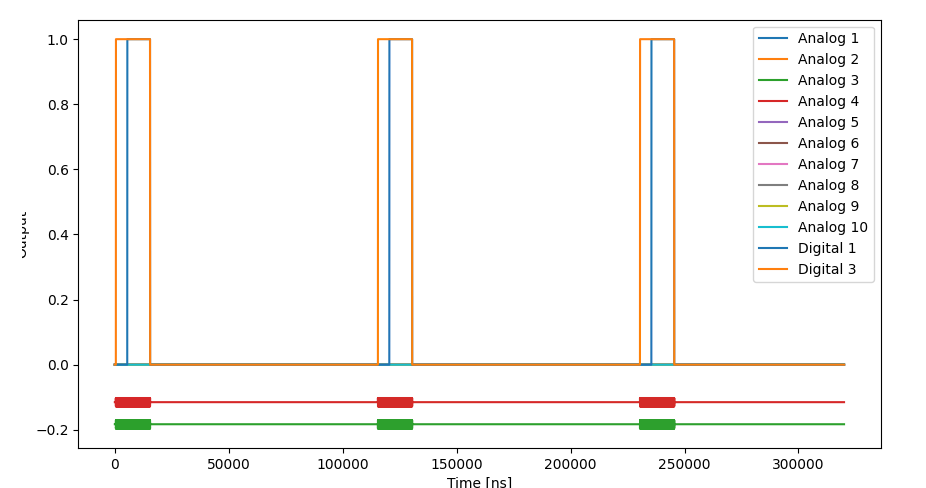


In [ ]:
%matplotlib qt

#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=100_000
config,qm=update_readout_lenght(pulse_len,config,qmm)

pulse_amp=0.125/2
config,qm=update_pulse_amplitude(pulse_amp,config,qmm) 

twoPhoton_len=100_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)

IF_pump=0.19728e9 # defines the IF of the pump 

amp_factor=0.4 #Amplitude factor of the pump 

n_avg = 100  # Number of averaging loops

cooldown_time = 100_000 // 4 #cooldown time between the averages

offset_1=0
offset_2=0
config,qm=update_offset(offset_1, offset_2,config,qmm)


with program() as raw_trace_prog:
    
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)
    
    update_frequency("fluxline",IF_pump)

    with for_(n, 0, n < n_avg, n + 1):
        
        play("pumping"*amp(amp_factor), 'fluxline')
        
        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        measure("fake_readout", "resonator", adc_st)
        
        wait(cooldown_time, "resonator") #Maybe need to cooldown both resonator and fluxline

    with stream_processing():
        
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        
        # Will save only last run:
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")

        
simulation = False
if simulation:
    
    simulation_config = SimulationConfig(
        duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, raw_trace_prog, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else: 
    #Execute the program     
    qm = qmm.open_qm(config)
    job = qm.execute(raw_trace_prog)

    results = fetching_tool(job, data_list=["adc1", "adc2", "adc1_single_run","adc2_single_run"], mode="wait_for_all")

    adc1, adc2, adc1_single_run, adc2_single_run = results.fetch_all()

    adc1 = u.raw2volts(adc1)
    adc2 = u.raw2volts(adc2)
    adc1_single_run = u.raw2volts(adc1_single_run)
    adc2_single_run = u.raw2volts(adc2_single_run)

    #Plotting 
    plt.figure()
    plt.subplot(121)
    plt.title("Single run")
    plt.plot(adc1_single_run, label="Input 1")
    plt.plot(adc2_single_run, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.ylabel("Signal amplitude [V]")
    plt.legend()

    plt.subplot(122)
    plt.title("Averaged run")
    plt.plot(adc1, label="Input 1")
    plt.plot(adc2, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.legend()
    plt.tight_layout()

    print("The mean offset of port 1 is: {}".format(np.mean(adc1)))
    print("The mean offset of port 2 is: {}".format(np.mean(adc2)))

# Single frequency IQ blob

Runs the IQ blob program for a single pump frequency that can be dfined with IF pump. The demodulation frequency is automatically taken as half of the total pump frequency

Need to make sure that the new updated IF frequency doesn't go over 350 MHz. 

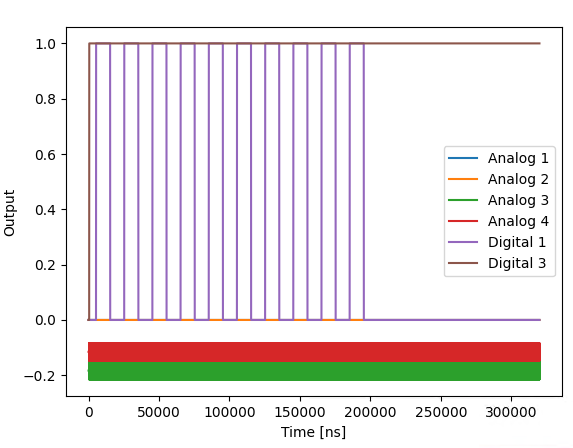

In [9]:
8.63-0.0008-8.5

0.12920000000000087

In [17]:
%matplotlib qt 

#Update the readout pulse 
Readout_Len= 50_000     #6_557_763 #length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_runs = 100_000 #Number of readout to do 

#Update the pump IF frequency 
IF_pump= 0.12860e9# defines the IF of the pump 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 


Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)
amp_factor=0.4 #Prefactor of the amplitude 
Offset_IF=0  #

points_delay=500_000//4 #Delay between readouts 

time,I,Q=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm)

Expected_time=n_runs *(Readout_Len+points_delay*4)
print("Expected time {}".format(Expected_time*1e-9))

2023-04-20 10:22:08,732 - qm - INFO - Flags: 
2023-04-20 10:22:08,732 - qm - INFO - Sending program to QOP
2023-04-20 10:22:09,194 - qm - INFO - Executing program
Execution stopped by user!
Expected time 55.0


## Plotting single frequency 

Execution stopped by user!
Average signal : 0.0001475671398590088


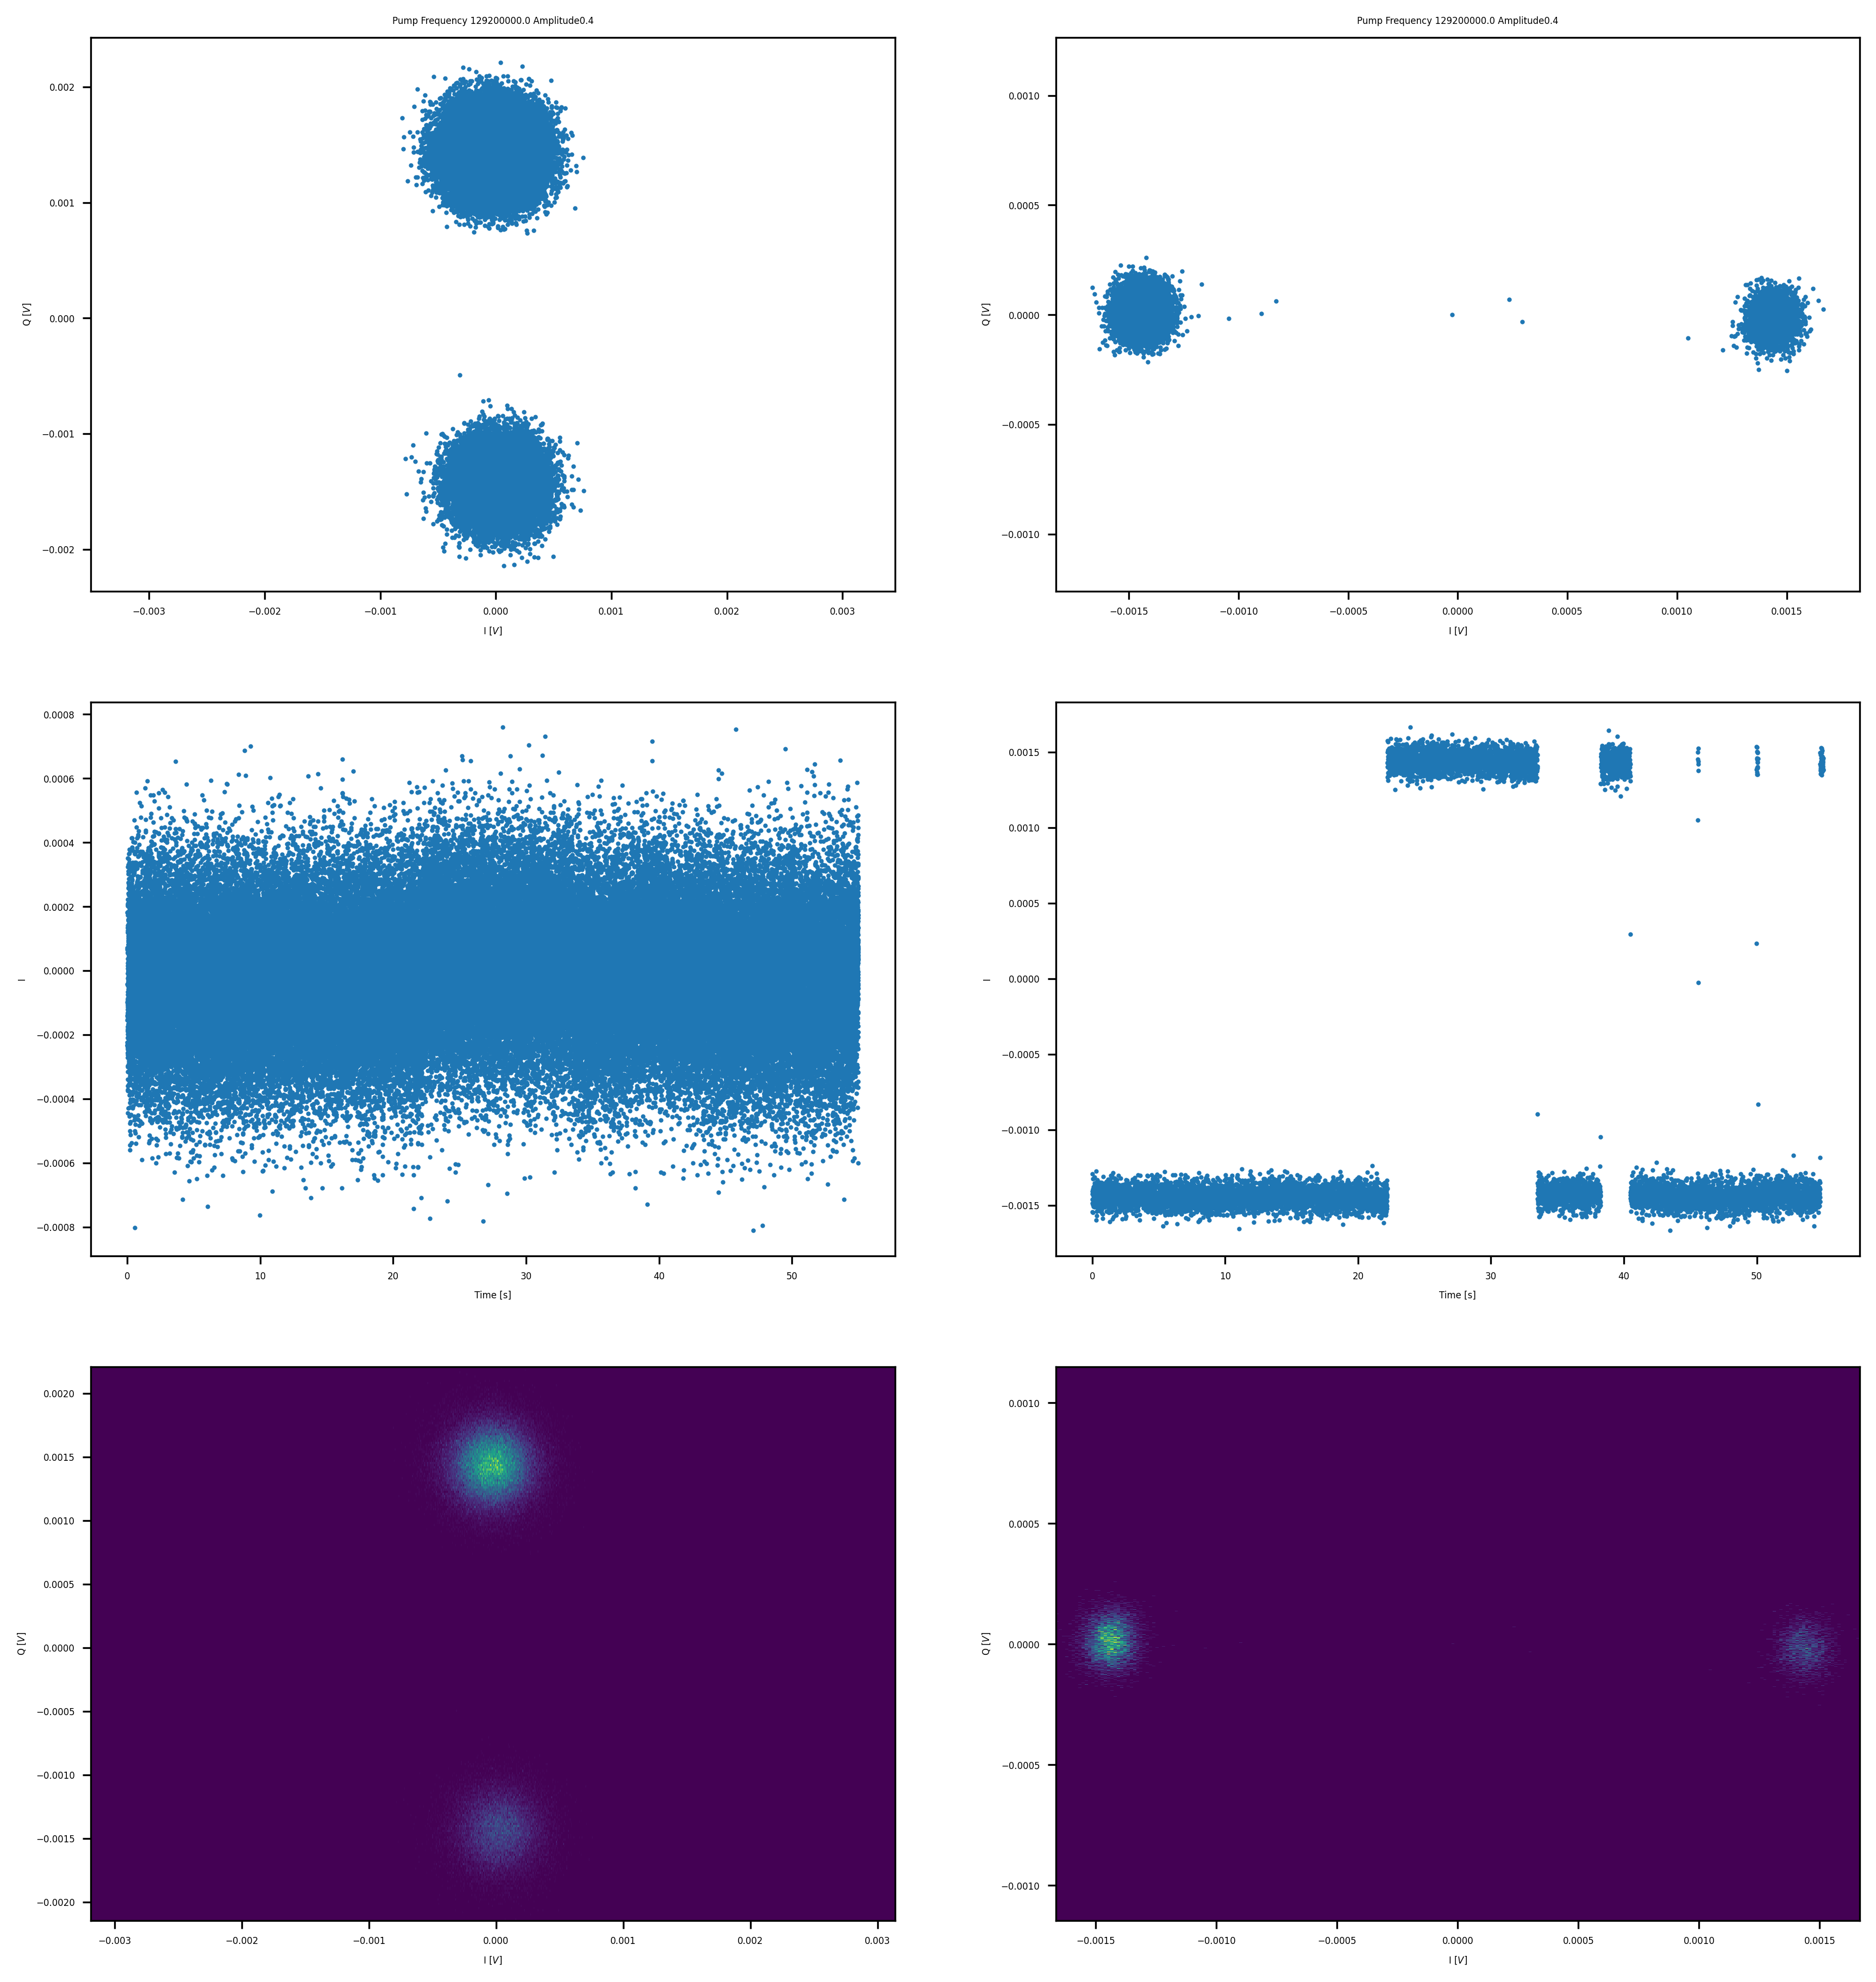

In [11]:
#Plotting with and without the noise reduction, would be better to get a single plotting function 

%matplotlib inline

n_bin=250 #bin size for the histogram 
figsize=(14,15)
fontsize=4
n_angle=100 #number of angles for the rotation 
n_avg=10 #number of average
dpi=300

plot_init_av_single(I,Q,time*1e-9,n_avg,n_bin,n_angle,figsize,fontsize,dpi)


## Jumps Fabrizio single frequency 

Wall time: 1min 23s


Text(0.5, 1.0, 'Number of jumps: 401')

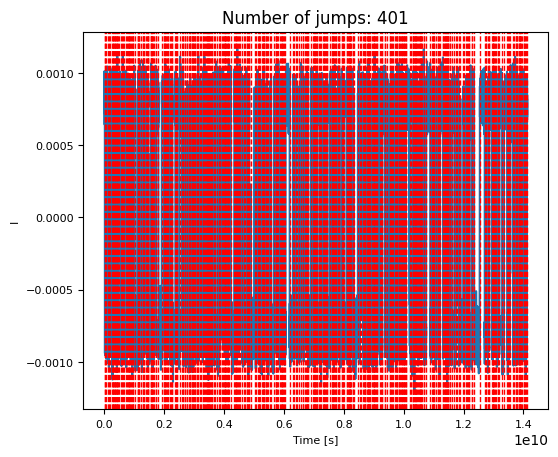

In [188]:
%%time
%matplotlib inline 

figsize=(6,5)
fontsize=8
nb_angle=100
n_avg=10

average_I,average_Q,time_average=rot_and_av_single(I,Q,time,nb_angle,n_avg)

#renormalize the data and find jumps 
length_array=average_I.shape[1] 
av = np.mean(abs(average_I))
jumps=an.find_jumps(average_I[0]/av,length_array)

#Plot I vs time and the identified jumps  jumps 
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=figsize,dpi=100)
ax=axs
ax.plot(time_average, average_I[0])
for j in jumps:
    ax.axvline(time_average[int(j)], c='r', lw=1, ls='--')
    
ax.set_xlabel("Time [s]",fontsize=fontsize)
ax.set_ylabel("I",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_title("Number of jumps: " +str(len(jumps)))

## Jumps Guillaume single frequency 

In [76]:
%%time 
%matplotlib inline


figsize=(6,5)
fontsize=8
nb_angle=100
n_avg=10


average_I,average_Q,time_average=rot_and_av_single(I,Q,time,nb_angle,n_avg)
time_average=time_average.reshape(1,time_average.shape[0])

#normalize 
average_I_norm = average_I/np.max(abs(average_I))

average_I_reduced=average_I_norm[(average_I_norm>=0.25) + (average_I_norm<=-0.25)]
time_average_reduced=time_average[(average_I_norm>=0.25) + (average_I_norm<=-0.25)]

zero_crossings = np.where(np.diff(np.sign(average_I_reduced)))[0] #finds the idx of crossing through zero 

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=figsize,dpi=100)
ax=axs
ax.plot(time_average[0], average_I[0])
for j in zero_crossings:
    ax.axvline(time_average[0,int(j)], c='r', lw=1, ls='--')
    
ax.set_xlabel("Time [s]",fontsize=fontsize)
ax.set_ylabel("I",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_title("Number of jumps: " +str(len(zero_crossings)))

ValueError: cannot reshape array of size 250000 into shape (1,1)

# Update single frequency IQ - Find parameters

In [32]:
#Update the readout pulse 
Readout_Len= 50_000     #6_557_763 #length of the readout pulse in ns 
init_Readout_Len=Readout_Len

#Update the pump IF frequency 
IF_pump= 0.197e9# defines the IF of the pump 
IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 


Readout_Delay = 1_000_000 //4 # Delay before the first readout in ns (convert from clockcycle)
amp_factor=0.25 #Prefactor of the amplitude 
Offset_IF=0  #


nb_desired_jumps=10
nb_points_between_jumps=5000


nb_angle=100
n_avg=10
init_points_delay=16
init_nruns=250_000
threshold=5e-4



I,Q,rot_I,rot_Q,time, points_delay, vaccum, n_runs, jumps, counter=Update_single_IQ_trace(config,IF_pump,IF_resonator,Offset_IF,amp_factor,qm,nb_desired_jumps,nb_points_between_jumps,init_points_delay=init_points_delay,nb_angle=100,n_avg=10,init_Readout_Len=init_Readout_Len,init_nruns=init_nruns,threshold=threshold )

########### Iteration number : 1 ##########
The program is initalized with :
A readout length of 50000 ns
The Number of points  250000
An initial point delay  6.4e-05 ms
Time for iteration  0.20840000000000003 min
2023-04-11 19:08:23,591 - qm - INFO - Flags: 
2023-04-11 19:08:23,591 - qm - INFO - Sending program to QOP
2023-04-11 19:08:24,055 - qm - INFO - Executing program
Out_of_qm
Execution stopped by user!
signal average 519.8972299608919 uV
Jumps found 6963
Success


# Update multiple frequency IQ- Find parameters 

In [62]:
span=0.8 * u.MHz # Span of the pumping 
df = 0.1 * u.MHz # Step of the pumping 0.01
IF_center=0.1973e9
freqs = np.arange(IF_center-span/2, IF_center+span/2, df) #sets of frequencies

freqs0=np.array([1.9690e+08, 1.9692e+08, 1.9694e+08, 1.9696e+08, 1.9698e+08]) #vacuum 
freqs1=np.arange(0.197e9,0.1971e9,0.00001e9)# first transition
freqs2=np.arange(0.1971e9, 0.19736e9, 0.02 *1e6) # flat part 
freqs3=np.arange(0.19736e9,0.1975e9,0.00001e9) #second transition
freqs4=np.arange(0.1975e9,0.1976e9, 0.02 *1e6)
freqs=np.concatenate((freqs0,freqs1,freqs2,freqs3,freqs4))
freqs

array([1.9690e+08, 1.9692e+08, 1.9694e+08, 1.9696e+08, 1.9698e+08,
       1.9700e+08, 1.9701e+08, 1.9702e+08, 1.9703e+08, 1.9704e+08,
       1.9705e+08, 1.9706e+08, 1.9707e+08, 1.9708e+08, 1.9709e+08,
       1.9710e+08, 1.9712e+08, 1.9714e+08, 1.9716e+08, 1.9718e+08,
       1.9720e+08, 1.9722e+08, 1.9724e+08, 1.9726e+08, 1.9728e+08,
       1.9730e+08, 1.9732e+08, 1.9734e+08, 1.9736e+08, 1.9737e+08,
       1.9738e+08, 1.9739e+08, 1.9740e+08, 1.9741e+08, 1.9742e+08,
       1.9743e+08, 1.9744e+08, 1.9745e+08, 1.9746e+08, 1.9747e+08,
       1.9748e+08, 1.9749e+08, 1.9750e+08, 1.9752e+08, 1.9754e+08,
       1.9756e+08, 1.9758e+08])

In [63]:
%%time
#The idea is that this program is used to get a first quick estimates. Therefore, it should be launched with a few numbers of nb_desired_jumps
# Moreover, we should use quite a high threshold, because anyway below the threshold, we will fix the readout_len to 50_000
%matplotlib qt 

#Update the readout pulse 
Readout_Len= 50_000    #Readout length in ns 
init_Readout_Len=Readout_Len


Readout_Delay = 1_000_000 //4 # Delay before the first readout in ns (convert from clockcycle)
amp_factor=0.25 #Prefactor of the amplitude 
Offset_IF=0  #

nb_desired_jumps=50
nb_points_between_jumps=5000

nb_angle=100
n_avg=10

init_points_delay=16
init_nruns=250_000
threshold=5e-4


save_data=True
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_parameter_IQ" # third folder 
meastype="0p25_amp_single_Readout_length" #Final file name 



Data={} #dictionnary to hold all the data 

for idx,IF_pump in enumerate(freqs) :
    print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))
    
    Data[IF_pump]={}
    
    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default                                                    
    I,Q,rot_I,rot_Q,time, points_delay, vaccum, n_runs, jumps, counter=Update_single_IQ_trace(config,IF_pump,IF_resonator,Offset_IF,amp_factor,qm,nb_desired_jumps,nb_points_between_jumps,init_points_delay=init_points_delay,nb_angle=100,n_avg=10,init_Readout_Len=init_Readout_Len,init_nruns=init_nruns,threshold=threshold )
    
    #Saving the data
    Data[IF_pump]["I"]=I
    Data[IF_pump]["Q"]=Q
    Data[IF_pump]["rot_I"]=rot_I
    Data[IF_pump]["rot_Q"]=rot_Q
    Data[IF_pump]["jumps"]=jumps
    Data[IF_pump]["counter"]=counter
    Data[IF_pump]["n_runs"]=n_runs
    Data[IF_pump]["time"]=time
    Data[IF_pump]["vaccum"]=vaccum
    Data[IF_pump]["points_delay"]=points_delay #returned in ns 
    
if save_data:
    datadict={}
    datadict["freqs"]=freqs
    datadict["Readout_Len"]=Readout_Len
    datadict["Readout_Delay"]=Readout_Delay*4
    datadict["Offset_IF"]=Offset_IF
    datadict["amp_factor"]=amp_factor
    datadict["nb_desired_jumps"]=nb_desired_jumps
    datadict["nb_points_between_jumps"]=nb_points_between_jumps 
    datadict["Data"]=Data
    datadict["config"]=config
    Data[IF_pump]["points_delay"]=points_delay
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

########################### Frequency 8696900000.0########################### 0.0
########### Iteration number : 1 ##########
The program is initalized with :
A readout length of 50000 ns
The Number of points  250000
An initial point delay  6.4e-05 ms
Time for iteration  0.20840000000000003 min
2023-04-11 19:17:20,113 - qm - INFO - Flags: 
2023-04-11 19:17:20,114 - qm - INFO - Sending program to QOP
2023-04-11 19:17:20,567 - qm - INFO - Executing program
Out_of_qm
Execution stopped by user!
signal average 73.11873102686756 uV
vaccum state
########################### Frequency 8696920000.0########################### 0.02127659574468085
########### Iteration number : 1 ##########
The program is initalized with :
A readout length of 50000 ns
The Number of points  250000
An initial point delay  6.4e-05 ms
Time for iteration  0.20840000000000003 min
2023-04-11 19:17:35,650 - qm - INFO - Flags: 
2023-04-11 19:17:35,650 - qm - INFO - Sending program to QOP
2023-04-11 19:17:36,115 - qm - INFO 

## Saving the parameters 

In [23]:
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_parameter_IQ" # third folder 
meastype="0p23_amp_test_1" #Final file name 

datadict={}
datadict["Readout_Len"]=Readout_Len
datadict["freqs"]=freqs
datadict["Readout_Delay"]=Readout_Delay*4
datadict["Offset_IF"]=Offset_IF
datadict["amp_factor"]=amp_factor
datadict["nb_desired_jumps"]=nb_desired_jumps
datadict["nb_points_between_jumps"]=nb_points_between_jumps 
datadict["Data"]=Data
datadict["config"]=config
an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

saving


In [65]:
#Loading data 
filepath=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_parameter_IQ\0p25_amp_single_Readout_length.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]

Data=npzfile["multidata"][()]["Data"]

## Plotting multiple runs

Plotting the results of the program to find the different optimap parameters 

In [68]:
# I think the idea will be to do that for like 50 jumps and then readapte everything to have better results 
# So to readapte, we want to plot everything 
%matplotlib qt
idx=4
bin_size=100
fontsize=5
figsize=(4,12)
FileName=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_plotting\0p25_amp_single_Readout_length_param"
movie=True
n_avg=10 # Number of average

def create_frame(idx,Data,FileName,bin_size,fontsize,movie=False):

    freqs=npzfile["multidata"][()]["freqs"]
    time=Data[freqs[idx]]["time"]
    Readout_Len=npzfile["multidata"][()]["Data"]
    points_delay=Data[freqs[idx]]["points_delay"]*1e-6
    
    n_runs=Data[freqs[idx]]['n_runs']
    jumps=Data[freqs[idx]]["jumps"]
    vaccum=Data[freqs[idx]]["vaccum"]
    
    freqs=npzfile["multidata"][()]["freqs"]
    rot_I=Data[freqs[idx]]["rot_I"]
    rot_Q=Data[freqs[idx]]["rot_Q"]
    time=Data[freqs[idx]]["time"]
    
    #average_data
    average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)
    rot_I=average_I
    rot_Q=average_Q
    time=time_average

    fig= plt.figure(figsize=figsize,dpi=300)

    ax = plt.subplot(311)
    ax.plot(rot_I[0],rot_Q[0],".",markersize=2)
    ax.set_title('Pump Frequency '+str(freqs[idx])+ "GHz"+" Frame: "+str(idx),fontsize=fontsize)
    ax.set_xlabel("I [$\mu V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$\mu V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax=plt.subplot(312)
    ax.set_title('Number of runs:'+str(n_runs)+ " Points_delay :"+str(points_delay)+" ms",fontsize=fontsize)
    plt.plot(time,rot_I[0], ".", markersize=2)
    plt.xlabel("Time [s]",fontsize=fontsize)
    plt.ylabel("Phase",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax = plt.subplot(313)
    ax.set_title('Number of jumps:'+str(len(jumps))+" Vaccum = "+str(vaccum),fontsize=fontsize)
    ax.hist2d(rot_I[0],rot_Q[0],bins=bin_size)
    ax.set_xlabel("I [$\mu V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$\mu V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_ylim(-0.0025, 0.0025) 
    ax.set_xlim(-0.0025, 0.0025)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    
    if movie:
        plt.savefig(FileName+f'/img_{idx}.png', 
                        transparent = False,  
                        facecolor = 'white'
                       )    
        plt.close()
    

if movie==True :
    for idx in range(len(Data)):
        create_frame(idx,Data,FileName,bin_size,fontsize,movie=True)
else:
    create_frame(idx,Data,FileName,bin_size,fontsize,movie=movie)

## Extract the Parameters

In [8]:
# If loaded 
filepath=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_parameter_IQ\0p25_amp_single_Readout_length.npz"

npzfile=np.load(filepath,allow_pickle=True)

In [9]:
# Based on the previous collected information, we now want to select the readout length and time 




nb_desired_jumps=100
nb_points_between_jumps=5000


Parameters={}
Total_time_vec=[]


#General parameters 
Parameters["Readout_Delay"]=npzfile["multidata"][()]["Readout_Delay"]
Parameters["Offset_IF"]=npzfile["multidata"][()]["Offset_IF"]
Parameters["amp_factor"]=npzfile["multidata"][()]["amp_factor"]
Parameters["freqs"]=npzfile["multidata"][()]["freqs"]
Parameters["freqs"]=npzfile["multidata"][()]["freqs"]
Parameters["Readout_Len"]=npzfile["multidata"][()]["Readout_Len"]
Parameters["nb_points_between_jumps"]=nb_points_between_jumps
Parameters["nb_desired_jumps"]=nb_desired_jumps


#Setting the parameters for the measurement 
freqs=Parameters["freqs"]
n_Data=npzfile["multidata"][()]["Data"]
#Rebuild the Data dictionnary :
        
        
for i in range(len(n_Data)):
    
    IF_pump=freqs[i]
    Parameters[IF_pump]={} # For each frequency 
    
    points_delay=n_Data[IF_pump]["points_delay"]
    n_runs=n_Data[IF_pump]["n_runs"]
    vaccum=n_Data[IF_pump]["vaccum"]
    jumps=n_Data[IF_pump]["jumps"]
    time=n_Data[IF_pump]["time"]
   
    #If we are in the vaccum case, we assign the minimum delay and the proper number of points 
    if vaccum:
        Parameters[IF_pump]["points_delay"]=16//4 # minimum readout 
        Parameters[IF_pump]["n_runs"]=nb_points_between_jumps*nb_desired_jumps
        
        Total_time=Parameters[IF_pump]["n_runs"]*(Parameters[IF_pump]["points_delay"]*4+Parameters["Readout_Len"])*1e-9
        Total_time_vec.append(Total_time)
        
        Parameters[IF_pump]["Total_time"]=np.around(Total_time/60, decimals=2)
        Parameters[IF_pump]["i"]=i
        
    else :
        
        time_per_jump=(time[-1]-time[0])/len(jumps)    
        update_points_delay= int((time_per_jump/ nb_points_between_jumps-Readout_Len)//4)
        
        update_n_runs=int(nb_points_between_jumps*nb_desired_jumps)
        
        
        if update_points_delay <=4:
            update_points_delay=16//4
            update_n_runs=int(nb_points_between_jumps*nb_desired_jumps)
        
        Parameters[IF_pump]["n_runs"]=int(update_n_runs)
        Parameters[IF_pump]["points_delay"]=int(update_points_delay)
        
        Total_time=int(Readout_Len+4*update_points_delay)*int(update_n_runs)*1e-9 # total time in seconds
        Total_time_vec.append(Total_time)
        
        Parameters[IF_pump]["Total_time"]=np.around(Total_time/60, decimals=2)
        Parameters[IF_pump]["i"]=i

print("The estimated time for the measurement is {} min".format(sum(Total_time_vec)/60))
Parameters

The estimated time for the measurement is 332.5562333333339 min


{'Readout_Delay': 1000000,
 'Offset_IF': 0,
 'amp_factor': 0.25,
 'freqs': array([1.9690e+08, 1.9692e+08, 1.9694e+08, 1.9696e+08, 1.9698e+08,
        1.9700e+08, 1.9701e+08, 1.9702e+08, 1.9703e+08, 1.9704e+08,
        1.9705e+08, 1.9706e+08, 1.9707e+08, 1.9708e+08, 1.9709e+08,
        1.9710e+08, 1.9712e+08, 1.9714e+08, 1.9716e+08, 1.9718e+08,
        1.9720e+08, 1.9722e+08, 1.9724e+08, 1.9726e+08, 1.9728e+08,
        1.9730e+08, 1.9732e+08, 1.9734e+08, 1.9736e+08, 1.9737e+08,
        1.9738e+08, 1.9739e+08, 1.9740e+08, 1.9741e+08, 1.9742e+08,
        1.9743e+08, 1.9744e+08, 1.9745e+08, 1.9746e+08, 1.9747e+08,
        1.9748e+08, 1.9749e+08, 1.9750e+08, 1.9752e+08, 1.9754e+08,
        1.9756e+08, 1.9758e+08]),
 'Readout_Len': 50000,
 'nb_points_between_jumps': 5000,
 'nb_desired_jumps': 100,
 196900000.0: {'points_delay': 4,
  'n_runs': 500000,
  'Total_time': 0.42,
  'i': 0},
 196920000.0: {'points_delay': 4,
  'n_runs': 500000,
  'Total_time': 0.42,
  'i': 1},
 196940000.0: {'points_

In [12]:
Parameters.pop(freqs[4])
Parameters.pop(freqs[5])
Parameters.pop(freqs[7])
Parameters.pop(freqs[9])
Parameters.pop(freqs[11])
Parameters.pop(freqs[13])
Parameters.pop(freqs[15])
Parameters.pop(freqs[17])
Parameters.pop(freqs[19])
Parameters.pop(freqs[20])
Parameters.pop(freqs[21])
Parameters.pop(freqs[23])
Parameters.pop(freqs[25])
Parameters.pop(freqs[27])

freqs_del=np.delete(Parameters["freqs"], [4,5,7,9,11,13,15,17,19,20,21,23,25,27])
Parameters.pop("freqs")
Parameters["freqs"]=freqs_del


KeyError: 196980000.0

In [11]:
Parameters

{'Readout_Delay': 1000000,
 'Offset_IF': 0,
 'amp_factor': 0.25,
 'Readout_Len': 50000,
 'nb_points_between_jumps': 5000,
 'nb_desired_jumps': 100,
 196900000.0: {'points_delay': 4,
  'n_runs': 500000,
  'Total_time': 0.42,
  'i': 0},
 196920000.0: {'points_delay': 4,
  'n_runs': 500000,
  'Total_time': 0.42,
  'i': 1},
 196940000.0: {'points_delay': 4,
  'n_runs': 500000,
  'Total_time': 0.42,
  'i': 2},
 196960000.0: {'points_delay': 4,
  'n_runs': 500000,
  'Total_time': 0.42,
  'i': 3},
 197010000.0: {'n_runs': 500000,
  'points_delay': 407064,
  'Total_time': 13.99,
  'i': 6},
 197030000.0: {'n_runs': 500000,
  'points_delay': 308344,
  'Total_time': 10.69,
  'i': 8},
 197050000.0: {'n_runs': 500000,
  'points_delay': 228169,
  'Total_time': 8.02,
  'i': 10},
 197070000.0: {'n_runs': 500000,
  'points_delay': 273110,
  'Total_time': 9.52,
  'i': 12},
 197090000.0: {'n_runs': 500000,
  'points_delay': 362494,
  'Total_time': 12.5,
  'i': 14},
 197120000.0: {'n_runs': 500000,
  'poi

In [13]:
# Modification
time_vec=[]
freqs=Parameters["freqs"]
for i in range(len(freqs)):
    time_vec.append(Parameters[freqs[i]]["Total_time"])
    
sum(time_vec)

142.40999999999977

In [128]:
len(Parameters["freqs"])
#len(Parameters)

33

# Run full measurement based on parameters

Using the parameters defined in the previous dictionnary, we run the program for each frequency 

In [14]:
%%time
%matplotlib qt

#Saving parameters 
save_data=True 
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_program_IQ" # third folder 
meastype="0p25_amp_single_Readout_length" #Final file name 



#general parmeters 
freqs=Parameters["freqs"]
Readout_Delay =int(Parameters["Readout_Delay"]//4)
Offset_IF=int(Parameters["Offset_IF"])
amp_factor=Parameters['amp_factor']

Readout_Len=int(Parameters["Readout_Len"])
config,qm=update_readout_lenght(Readout_Len,config,qmm)
    
Data_full={}

#for each pump frequency 
for idx in range(len(freqs)):
    
    IF_pump=float(freqs[idx])
    
    Data_full[IF_pump]={}
    
    #Parameters for taking a single trace 
    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout
    
    points_delay=int(Parameters[IF_pump]["points_delay"])
    n_runs=int(Parameters[IF_pump]["n_runs"])
    
   
    
    #Run the program 
    time, I, Q =single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm)
    
    Data_full[IF_pump]["I"]=I
    Data_full[IF_pump]["Q"]=Q
    Data_full[IF_pump]["time"]=time
    
    print(IF_pump)
    print(idx/len(freqs))
    time_package.sleep(1)
    plt.close()
    
if save_data:

    # Saving the data 
    datadict={}
    datadict["freqs"]=freqs
    datadict["Data"]=Data_full
    datadict["configuration"]=config
    datadict["Parameters"]=Parameters

    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

2023-04-12 08:53:40,238 - qm - INFO - Flags: 
2023-04-12 08:53:40,238 - qm - INFO - Sending program to QOP
2023-04-12 08:53:41,106 - qm - INFO - Executing program
196900000.0
0.0
Execution stopped by user!
2023-04-12 08:54:08,736 - qm - INFO - Flags: 
2023-04-12 08:54:08,736 - qm - INFO - Sending program to QOP
2023-04-12 08:54:09,198 - qm - INFO - Executing program
196920000.0
0.030303030303030304
Execution stopped by user!
2023-04-12 08:54:37,237 - qm - INFO - Flags: 
2023-04-12 08:54:37,238 - qm - INFO - Sending program to QOP
2023-04-12 08:54:37,664 - qm - INFO - Executing program
196940000.0
0.06060606060606061
Execution stopped by user!
2023-04-12 08:55:05,166 - qm - INFO - Flags: 
2023-04-12 08:55:05,167 - qm - INFO - Sending program to QOP
2023-04-12 08:55:05,968 - qm - INFO - Executing program
196960000.0
0.09090909090909091
Execution stopped by user!
2023-04-12 08:55:33,513 - qm - INFO - Flags: 
2023-04-12 08:55:33,513 - qm - INFO - Sending program to QOP
2023-04-12 08:55:33,

In [ ]:
# Saving the data 
cooldown_date="2023_03_31" #top folder 
device="Run01" #second folder 
name="104_program_IQ" # third folder 
meastype="0p23_amp_3" #Final file name 


datadict={}
datadict={}
datadict["freqs"]=freqs
datadict["Data"]=Data_full
datadict["configuration"]=config
datadict["Parameters"]=Parameters

an.an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=r"C:\Users\hqclabo\Documents\Data\gbeaulieu\Two_Photon\\")

In [22]:
#Loading the data 
filepath=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_program_IQ\0p25_amp_single_Readout_length.npz"

npzfile=np.load(filepath,allow_pickle=True)

Data_full=npzfile["multidata"][()]["Data"]
freqs=npzfile["multidata"][()]["freqs"]

## Ploting for multiple runs 

In [29]:
# Rotation and average of all the datas 
%matplotlib inline
nb_angle=150
n_avg=10
threshold=5e-4

Data_full_av={}

for i in range(len(freqs)):
    
    vaccum=False 
    IF_pump=float(freqs[i])
    Data_full_av[IF_pump]={}
    
    I=np.reshape(Data_full[IF_pump]["I"],(1, Data_full[IF_pump]["I"].shape[0]))
    Q=np.reshape(Data_full[IF_pump]["Q"],(1, Data_full[IF_pump]["Q"].shape[0]))
    time=Data_full[IF_pump]["time"]
    rot_I,rot_Q=an.rotate_data(I,Q,nb_angle)
    average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)

    Data_full_av[IF_pump]["I"]=average_I
    Data_full_av[IF_pump]["Q"]=average_Q
    Data_full_av[IF_pump]["time"]=time_average
    
    av = np.mean(abs(average_I))
    if av<threshold:
        vaccum=True
    
    Data_full_av[IF_pump]["vaccum"]=vaccum
    
Data_full_av[IF_pump]["freqs"]=freqs

In [31]:
%matplotlib qt
idx=22
bin_size=150
fontsize=8
FileName=r"C:\Users\HQClabo\Documents\Data\gbeaulieu\Two_Photon\2023_03_31\Run01\104_plotting\0p25_amp_single_Readout_length"
movie=True
figsize=(4,12)

def create_frame(idx,Data_full_av,FileName,bin_size,fontsize,figsize,movie=False):

    IF_pump=freqs[idx]
    I=Data_full_av[IF_pump]["I"]
    Q=Data_full_av[IF_pump]["Q"]
    time=Data_full_av[IF_pump]["time"]

    fig= plt.figure(figsize=figsize,dpi=300)

    ax = plt.subplot(311)
    ax.plot(I[0,:],Q[0,:],".",markersize=2)
    ax.set_title('Pump Frequency '+str(freqs[idx])+ "GHz"+" Frame: "+str(idx),fontsize=fontsize)
    ax.set_xlabel("I [$\mu V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$\mu V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.set_ylim(-0.002, 0.002) 
    ax.set_xlim(-0.002, 0.002)

    ax=plt.subplot(312)
    plt.plot(time,I[0,:], ".", markersize=2)
    plt.xlabel("Time [s]",fontsize=fontsize)
    plt.ylabel("Phase",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax = plt.subplot(313)
    ax.hist2d(I[0,:],Q[0,:],bins=bin_size)
    ax.set_xlabel("I [$\mu V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$\mu V$]",fontsize=fontsize)
    ax.set_ylim(-0.0025, 0.0025) 
    ax.set_xlim(-0.0025, 0.0025)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    
    
    if movie:
        plt.savefig(FileName+f'/img_{idx}.png', 
                        transparent = False,  
                        facecolor = 'white'
                       )    
        plt.close()
    
if movie==True :
    for idx in range(len(freqs)):
        create_frame(idx,Data_full_av,FileName,bin_size,fontsize,figsize,movie=True)
else:
    create_frame(idx,Data,FileName,bin_size,fontsize,figsize,movie=movie)  

## Estimate number of jumps 

In [93]:

zero_crossings=[]

for i in range(len(freqs)):
    IF_pump=freqs[i]
    average_I=Data_full_av[IF_pump]["I"]
    average_Q=Data_full_av[IF_pump]["Q"]
    time_average=Data_full_av[IF_pump]["time"]
    vaccum=Data_full_av[IF_pump]["vaccum"]
    
    time_average=time_average.reshape(1,time_average.shape[0])
    average_I_norm = average_I/np.max(abs(average_I))

    average_I_reduced=average_I_norm[(average_I_norm>=0.25) + (average_I_norm<=-0.25)]
    time_average_reduced=time_average[(average_I_norm>=0.25) + (average_I_norm<=-0.25)]

    if vaccum is not True: 
        zero_crossings.append(len( np.where(np.diff(np.sign(average_I_reduced)))[0])) #finds the idx of crossing through zero 
    else:
        zero_crossings.append(0)

